In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

from torch.utils.data import DataLoader, TensorDataset

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# import torchattacks
# from torchattacks import PGD
import matplotlib.pyplot as plt 


In [0]:
# from torchattacks import RPGD

In [0]:
# epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = '/gdrive/My Drive/Tmp/cifar_net.pth' #pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [4]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# simply define a silu function
def srelu(input, slope):
    return slope * F.relu(input)

class SReLU(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input, slope):
        return srelu(input, slope) # simply apply already implemented SiLU

In [6]:
class Net(nn.Module):
    def __init__(self, slope):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.slope = slope

    def forward(self, x):
        x = self.pool(srelu(self.conv1(x), self.slope))
        x = self.pool(srelu(self.conv2(x), self.slope))
        x = x.view(-1, 16 * 5 * 5)
        x = srelu(self.fc1(x), self.slope)
        x = srelu(self.fc2(x), self.slope)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# # Initialize the network
# model = Net().to(device)

# # Load the pretrained model
# model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# # Set the model in evaluation mode. In this case this is for the Dropout layers
# model.eval()

CUDA Available:  True


In [7]:
transform = transforms.Compose( 
    [transforms.ToTensor()]) 


# cifar10_train = dsets.CIFAR10(root='./data', train=True,
#                                        download=True, transform=transform)
cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=1,
                                        shuffle=False, num_workers=1)


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def test( model, device, test_loader, epsilon, myTarget):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    # import pdb; pdb.set_trace()
    for data, target in test_loader:

        # Send the data and label to the device
        data, target, myTarget = data.to(device), target.to(device), myTarget.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        if init_pred.item() == myTarget.item():            
            continue

        # Calculate the loss
        # loss = F.nll_loss(output, target)

        loss = F.nll_loss(output, myTarget)        

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, -1*data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == myTarget.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
#         else:
#             # Save some adv examples for visualization later
#             if len(adv_examples) < 5:
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [5]:
epsilons = [0, 0.003, 0.007, 0.01, 0.05, 0.1 ]
slopes   = [.5, 1, 2, 5, 10, 100]
symbs = ['*-', 'o-', 's-', 'd-', '+-', 'x-', '^-', '<-']

xx

all_all_accuracies = []

for num in range(10):

    all_accuracies = []
    all_examples = []

    # Run test for each slope
    for sl in slopes:
        print(f'\n Running class={classes[num]} slope={sl} ... ')
        # Initialize the network
        model = Net(sl).to(device)

        # Load the pretrained model
        model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

        # Set the model in evaluation mode. In this case this is for the Dropout layers
        model.eval()

        # Run test for each epsilon
        def_accuracies = []
        def_examples = []
    #     myTarget = torch.tensor([2])    
        for eps in epsilons:
            myTarget = torch.tensor([num]) #torch.randint(10, (1,1)).squeeze(0)        
    #         myTarget = torch.randint(10, (1,1)).squeeze(0)                
            acc, ex = test(model, device, test_loader, eps, myTarget)
            def_accuracies.append(acc)
#             def_examples.append(ex)

        all_accuracies.append(def_accuracies)
#         all_examples.append(def_examples)

    all_all_accuracies.append(all_accuracies)
    
    all_accuracies = np.array(all_accuracies)
    # all_accuracies = all_accuracies.T    
    fig =plt.figure(figsize=(5,5))
    for idx in range(len(all_accuracies)):
        plt.plot(all_accuracies[idx,:], symbs[idx])

    #     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
    plt.yticks(np.arange(0, .5, step=0.1))
    plt.xticks(np.arange(0, len(epsilons), step=1), epsilons)
    plt.title(f"Accuracy vs Epsilon (converting to {classes[num]})")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.legend(slopes)
    plt.show()
    fig.savefig(f'/gdrive/My Drive/Tmp/Targeted/plot-{classes[num]}.png')

np.save(f'/gdrive/My Drive/Tmp/Targeted/CIFAR_slopes.npy', all_all_accuracies)    


NameError: ignored

In [0]:
all_all_accuracies = np.load(f'/gdrive/My Drive/Tmp/Targeted/CIFAR_slopes.npy')

In [0]:
np.save(f'/gdrive/My Drive/Tmp/Targeted/CIFAR_slopes_FINAL.npy', all_all_accuracies)

In [0]:
all_res = np.array(all_all_accuracies)
all_res_m = all_res.mean(axis=0).T

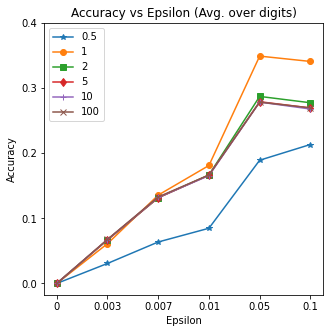

In [9]:
fig =plt.figure(figsize=(5,5))
for idx in range(len(all_res_m)):
    plt.plot(all_res_m[:,idx], symbs[idx])

#     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
plt.yticks(np.arange(0, .5, step=0.1))
plt.xticks(np.arange(0, 6, step=1), epsilons)
plt.title(f"Accuracy vs Epsilon (Avg. over digits)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(slopes)
plt.show()
fig.savefig(f'/gdrive/My Drive/Tmp/Targeted/CIFAR_avg.png')


In [0]:
# torch.save(all_accuracies,'/gdrive/My Drive/Tmp/accs_CIFAR_Targeted.npy')

In [0]:
model_1 = Net(1).to(device)
model_1.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model_1.eval()

model_2 = Net(100).to(device)
model_2.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model_2.eval()


# Run test for each epsilon
def_examples_1 = []
def_examples_2 = []

eps = .1

myTarget = torch.tensor([0]) #torch.randint(10, (1,1)).squeeze(0)        

# test_loader_2 = torch.utils.data.DataLoader(cifar10_test, batch_size=1,
#                                         shuffle=False, num_workers=1)

_, ex = test(model_1, device, test_loader, eps, myTarget)
def_examples_1.append(ex)

_, ex = test(model_2, device, test_loader, eps, myTarget)
def_examples_2.append(ex)
    
    

Epsilon: 0.1	Test Accuracy = 2716 / 10000 = 0.2716
Epsilon: 0.1	Test Accuracy = 2994 / 10000 = 0.2994


In [0]:
x,y = (img, label)

In [0]:
y

tensor([3])

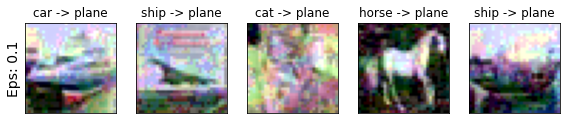

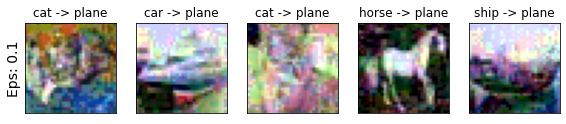

In [0]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for j in range(len(def_examples_1[0])):
    cnt += 1
    plt.subplot(1,len(def_examples_1[0]),cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel("Eps: {}".format(eps), fontsize=14)
    orig,adv,ex = def_examples_1[0][j]
    plt.title("{} -> {}".format(classes[orig], classes[adv]))
    plt.imshow(ex.transpose(1,2,0), cmap="gray")
plt.tight_layout()
plt.show()

cnt = 0
plt.figure(figsize=(8,10))
for j in range(len(def_examples_2[0])):
    cnt += 1
    plt.subplot(1,len(def_examples_2[0]),cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel("Eps: {}".format(eps), fontsize=14)
    orig,adv,ex = def_examples_2[0][j]
    plt.title("{} -> {}".format(classes[orig], classes[adv]))
    plt.imshow(ex.transpose(1,2,0), cmap="gray")
plt.tight_layout()
plt.show()